# **Algoritmi Genetici per l'ottimizzazione di modelli di Machine Learning**

In questo Notebook viene presentata una applicazione degli Algoritmi Genetici nel campo del Machine Learning.

Lo scopo è quello di ottimizzare modelli di **Regressione** **Lineare** tenendo conto delle ***performance*** e della ***complessità*** dei modelli stessi.

## **Cenni sulle tecniche di Model Selection**

Per **Model Selection** si intende il processo di selezione di un modello di Machine Learning all'interno di una collezione di modelli, questi possono essere di tipologia differente (*Alberi di decisione*, *Regressione lineare*, *Reti neurali* ...) oppure possono essere dello stesso tipo ma differire, ad esempio, per i valori assegnati agli iperparametri o per il numero di variabili coinvolte.

Scegliere il **migliore** tra questi spesso voler dire non considerare esclusivamente le prestazioni ma anche altre caratteristiche come la **complessità** o l'**interpretabilità** del modello.

Nello specifico, in questo lavoro si vuole selezionare il modello di **Regressione Lineare** che fornisce il miglior compromesso tra *accuratezza* e *complessità*.

Al fine di poter quantificare la bontà di tale compromesso è possibile ricorrere ad alcuni indici che tengono conto di entambi questi parametri.

### **Akaike Information Criterion** (AIC)

Per un modello di Regression Lineare può essere calcolato come
$$
AIC = n * log(\frac{RSS}{n}) + 2k
$$
Dove $k$ rappresenta il numero di parametri stimati del modello (coefficienti delle variabili + intercetta), $RSS$ stà per *Residual Sum of Squares* ed $n$ rappresenta il numero di esempi utilizzati per l'addestamento.

Considerati due modelli $M_1$ ed $M_2$ se $AIC(M_1) < AIC(M_2)$ allora si può dire che $M_1$ è **preferibile** ad $M_2$.

### **Bayesian Information Criteria** (BIC) :

Per un modello di Regression Lineare può essere calcolato come
$$
BIC = n * log(\frac{RSS}{n}) + log(n) * k
$$
Esattamente come avviene per $AIC$ un modello con un valore minore di $BIC$ è preferibile rispetto ad un modello con un valore più alto.

### **Adjusted R<sup>2</sup>** : 

Per un modello di Regression Lineare può essere calcolato come
$$
{R^2}_{adj} = 1 - \frac{\frac{RSS}{(n - k - 1)}}{\frac{TSS}{(n - 1)}}
$$
Dove $TSS$ stà per *Total Sum of Squares*.

Al contrario degli indici precedenti, questo criterio induce a preferire modelli con un **valore più alto**.

Dal momento in cui la misura della **complessità** del modello è data dal numero di variabili utilizzate, è facile capire che trovare la migliore combinazione di queste significa dover testare $2^p$ modelli, con $p$ = numero di features del dataset.

Questo approccio risulta inapplicabile per la maggior parte di problemi reali, ad esempio se $p = 20$ -> $2^p = 1.048.576$.

Per questo motivo sono stati introdotti metodi che cercano di limitare il numero di modelli da testre, tra questi citiamo:

- **Forward Selection**
- **Backward Selection**
- **Stepwise Selection**

In questo lavoro si vuole invece testare l'efficacia di un approccio basato su **Algoritmi Genetici** e confrontare i risultati con i metodi sopra elencati.

## **Import**

In [1]:
import random
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from itersel import *
from genetic.problem import Element, GAProblem, MultiThreadGAProblem
from genetic.evolution import GeneticSolver, MultiThreadGeneticSolver
from genetic.crossover import uniform_crossover
import matplotlib.pyplot as plt

## **Dataset**

Caricamento

In [2]:
credit_df = pd.read_csv("dataset/credit.csv")
credit_df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


Info sul dataset

In [3]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Income     400 non-null    float64
 1   Limit      400 non-null    int64  
 2   Rating     400 non-null    int64  
 3   Cards      400 non-null    int64  
 4   Age        400 non-null    int64  
 5   Education  400 non-null    int64  
 6   Gender     400 non-null    object 
 7   Student    400 non-null    object 
 8   Married    400 non-null    object 
 9   Ethnicity  400 non-null    object 
 10  Balance    400 non-null    int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 34.5+ KB


In [4]:
credit_df.describe()

,Income,Limit,Rating,Cards,Age,Education,Balance
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,45.218885,4735.600000,354.940000,2.957500,55.667500,13.450000,520.015000
std,35.244273,2308.198848,154.724143,1.371275,17.249807,3.125207,459.758877
min,10.354000,855.000000,93.000000,1.000000,23.000000,5.000000,0.000000
25%,21.007250,3088.000000,247.250000,2.000000,41.750000,11.000000,68.750000
50%,33.115500,4622.500000,344.000000,3.000000,56.000000,14.000000,459.500000
75%,57.470750,5872.750000,437.250000,4.000000,70.000000,16.000000,863.000000
max,186.634000,13913.000000,982.000000,9.000000,98.000000,20.000000,1999.000000


Estrazione della variabile target

In [5]:
X_credit = credit_df.drop("Balance", axis = 1)
Y_credit = np.log1p(credit_df["Balance"])

Encoding delle variabili categoriche

In [6]:
X_credit = pd.get_dummies(X_credit, drop_first=True)
X_credit.head()

,Income,Limit,Rating,Cards,Age,Education,Gender_Male,Student_Yes,Married_Yes,Ethnicity_Asian,Ethnicity_Caucasian
0,14.891,3606,283,2,34,11,1,0,1,0,1
1,106.025,6645,483,3,82,15,0,1,1,1,0
2,104.593,7075,514,4,71,11,1,0,0,1,0
3,148.924,9504,681,3,36,11,0,0,0,1,0
4,55.882,4897,357,2,68,16,1,0,1,0,1


## **Algoritmo Genetico**

### Funzione Obiettivo

Definizione di una funzione obiettivo da ottimizzare.

Tale funzione costruisce un modello di Regressione Lineare sulla base dei dati ricevuti in ingresso, e restituisce il valore dei criteri di valutazione (*AIC*, *BIC* ed *Adjusted R<sup>2</sup>*)

In [7]:
def eval_lin_reg(X: pd.DataFrame, Y: pd.Series, return_model: bool = False):
    '''
        Restituisce il valore del criterio di valutazione selezionato di un modello 
        di Regressione Lineare costruito sulla base dei dati X ed Y.

        Parametri:

        - `X`: Variabili di input del modello di Regressione Lineare
        - `Y`: Variabili di output del modello di Regressione Lineare
        - `return_model`: indica se il modello costruito deve essere restituito dalla funzione. Default = `False`

        Return:

        La funzione restituisce un oggetto contenente i valori dei criteri di selezione, 
        il Mean Squared Error, il Residual Sum of Squares ed il modello costruito (se `return_model = True`).
    '''
    # Definizione del modello
    model = LinearRegression()
    # Addestramento
    model.fit(X, Y)
    # Predizione
    Y_pred = model.predict(X)
    # Mean Squared Error
    mse = mean_squared_error(Y, Y_pred)
    # Residual Sum of Squares
    rss = np.sum((Y - Y_pred) ** 2)
    # Numero di parametri del modello
    num_params = len(model.coef_) + 1
    # Numero di record del dataset
    n = len(Y)
    # AIC
    aic = n * np.log(mse) + 2 * num_params
    # BIC
    bic = n * np.log(mse) + np.log(n) * num_params
    # Adj. R^2
    Y_bar = np.full(shape = (n,), fill_value = np.sum(Y, axis = 0) / n)
    tss = np.sum((Y - Y_bar) ** 2, axis = 0)
    rss = np.sum((Y - Y_pred) ** 2, axis = 0)
    adjr = 1 - (rss / (n - num_params - 1)) / (tss / (n - 1))
    
    result = {
        AIC:aic, BIC:bic, ADJ_R2:adjr, RSS:rss, "_coef": model.coef_
    }
    if return_model:
        result["model"] = model
    return result

### Definizione del problema

Caratteristiche:
- **Soluzione** = vettore di valori booleani di dimensione pari al numero di features del dataset. 
Ogni valore indica se la corrispondente variabile deve essere utilizzata o meno nella costruzione del modello
- **Crossover** = Crossover Uniforme
- **Mutazione** = Negazione di un elemento casuale
- **Meccanismo di correzione** = Qualora una soluzione dovesse presentare tutti valori negativi (False), viene reso positivo un elemento a caso

In [8]:
class ModelSelectionProblem(GAProblem):
    '''
        Definizione di un problema di Model Selection risolvibile tramite Algoritmi Genetici
    '''
    def __init__(self, X: pd.DataFrame, Y: pd.Series, colnames: np.ndarray = None, criterion: int = AIC, transform_categorical: bool = False) -> None:
        self.X = X
        self.Y = Y
        if colnames == None:
            self.colnames = self.X.columns.to_numpy()
        else:
            self.colnames = colnames
        self.sol_dim = len(self.colnames)
        if criterion != AIC and criterion != BIC and criterion != ADJ_R2:
            raise ValueError("Invalid selection criterion. Must be AIC or BIC or ADJ_R2.")
        self.criterion = criterion
        self.transform_categorical = transform_categorical        

    def correct_solution(self, sol: np.ndarray):
        '''
            Funzione di correzione delle soluzioni.

            Se tutti gli elementi della soluzione sono `False`, 
            viene scelto casualmente un elemento ed impostato a `True`
        '''
        if np.sum(sol) == 0:
            sol[random.randrange(0, self.sol_dim)] = True

    def init_pop(self, n: int) -> list:
        pop = []
        for _ in range(n):
            elm = np.random.choice([False, True], self.sol_dim, replace = True)
            # Correzione
            self.correct_solution(elm)
            pop.append(elm)
        return pop

    def evaluate(self, elm: Element) -> None:
        sol = elm.solution
        # Costruzione del dataset a partire dalla soluzione
        cols = self.colnames[sol]
        X_eval = self.X[cols]
        if self.transform_categorical:
            X_eval = pd.get_dummies(X_eval)
        # Valutazione del modello
        result = eval_lin_reg(X_eval, self.Y, return_model = False)
        elm.fitness = result[self.criterion]

    def crossover(self, sol1: object, sol2: object) -> 'list | tuple':
        _sol1 = self.copy(sol1)
        _sol2 = self.copy(sol2)
        # Crossover uniforme
        ch1, ch2, _ = uniform_crossover(_sol1, _sol2)
        ch1 = np.array(ch1, dtype=bool)
        ch2 = np.array(ch2, dtype=bool)
        # Correzione
        self.correct_solution(ch1)
        self.correct_solution(ch2)

        return ch1, ch2

    def mutate(self, sol: object) -> object:
        _sol = self.copy(sol)
        # Indice casuale
        idx = random.randrange(0, self.sol_dim)
        # Negazione
        _sol[idx] = not _sol[idx]
        # Correzione
        self.correct_solution(_sol)
        return _sol

    def copy(self, sol: object) -> object:
        return np.copy(sol)


In [9]:
problem = ModelSelectionProblem(X = X_credit, 
                                Y = Y_credit,
                                criterion = AIC,
                                transform_categorical = False)

### Algoritmo risolutivo

Caratteristiche:
- **Dimensione popolazione iniziale** = 50
- **Epoche** = 30
- **Strategia di aggiornamento della popolazione** = Aggiornamento Generazionale
- **Strategia di selezione del mating pool** = Roulette Wheel
- **Elitismo** = Sì
- **Obiettivo** = Minimizzazione

In [10]:
pop_size = 50
epochs = 30
solver = GeneticSolver(problem, 
                       pop_size = pop_size, 
                       p_cross = 0.9, 
                       p_mut = 0.3,
                       pop_update_strategy="generational", 
                       selection_strategy="roulette_wheel",
                       use_elit = True,
                       minimize = True)

Funzioni di scheduling delle probailità di mutazione e di crossover

In [11]:
def pmut_sched(p_mut, epoch, best, last_update, fit_history):
    '''
        Scheduler della probabilità di mutazione
    '''
    if last_update == 0:
        return 0.1
    return min(0.9, p_mut + 0.05)

def pcross_sched(p_cross, epoch, best, last_update, fit_history):
    '''
        Scheduler della probabilità di crossover
    '''
    if last_update == 0:
        return 0.9
    return max(0.1, p_cross - 0.05)

### Soluzione

In [12]:
solver.use_p_mut_scheduler(pmut_sched)
solver.use_p_cross_scheduler(pcross_sched)
best_gaAIC = solver.run(epochs = epochs, verbose = False, seed = 123)
best_comb = X_credit.columns[best_gaAIC.solution]
print("Combinazione migliore:", best_comb.to_list())
print("Valore criterio:", best_gaAIC.fitness)

Combinazione migliore: ['Income', 'Limit', 'Cards', 'Student_Yes', 'Ethnicity_Caucasian']
Valore criterio: 237.01745761308197


Cronologia della fitness migliore

Last Update: 16


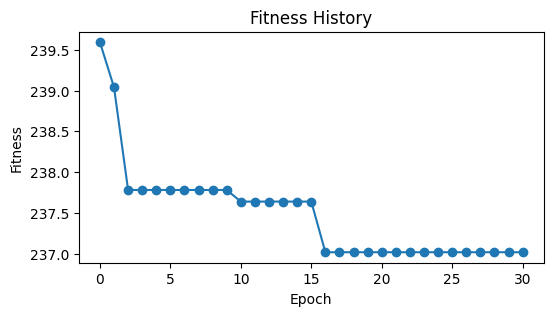

In [13]:
print("Last Update:", epochs - solver.last_update) # Epoca dell'ultimo aggiornamento del miglior individuo 
plt.figure(figsize = (6,3))
plt.plot(solver.fit_history, "o-")
plt.title("Fitness History")
plt.xlabel("Epoch")
plt.ylabel("Fitness")
plt.show()

## **Metodi di Selezione Iterativa**

#### **Exhaustive Selection**

Dato il numero contenuto di variabili del dataset, in questo caso è accettabile testare tutte le combinazioni di queste al fine di avere un valore di verità utilizzabile come riferimento per la valutazione dei risultati forniti dagli altri algoritmi. 

In [14]:
# AIC
best_eAIC, n_tested = exhaustive_selection(X_credit, Y_credit, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = AIC, minimize=True)
print("Numero di modelli testati:", n_tested)
print("Combinazione migliore:", best_eAIC[COMB].to_list())
print("Valore criterio:", best_eAIC[CRT_VALUE])
print("Valore RSS:", best_eAIC[RSS])

Numero di modelli testati: 2047
Combinazione migliore: ['Income', 'Limit', 'Cards', 'Student_Yes', 'Ethnicity_Caucasian']
Valore criterio: 237.01745761308197
Valore RSS: 702.0525025178742


In [15]:
# BIC
best_eBIC, n_tested = exhaustive_selection(X_credit, Y_credit, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = BIC, minimize=True)
print("Numero di modelli testati:", n_tested)
print("Combinazione migliore:", best_eBIC[COMB].to_list())
print("Valore criterio:", best_eBIC[CRT_VALUE])
print("Valore RSS:", best_eBIC[RSS])

Numero di modelli testati: 2047
Combinazione migliore: ['Income', 'Limit', 'Student_Yes']
Valore criterio: 255.47900304816386
Valore RSS: 713.5463592709091


In [16]:
# ADJ. R2
best_eR2, n_tested = exhaustive_selection(X_credit, Y_credit, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = ADJ_R2, minimize=False)
print("Numero di modelli testati:", n_tested)
print("Combinazione migliore:", best_eR2[COMB].to_list())
print("Valore criterio:", best_eR2[CRT_VALUE])
print("Valore RSS:", best_eR2[RSS])

Numero di modelli testati: 2047
Combinazione migliore: ['Income', 'Limit', 'Cards', 'Education', 'Student_Yes', 'Ethnicity_Caucasian']
Valore criterio: 0.7592484377351099
Valore RSS: 699.6364477026109


#### **Forward Selection**

1. Sia $p$ il numero totale di varaibili
2. Comincia con $M_0$ = modello vuoto e $V$ = insieme di tutte le variabili
3. for $i = 1 ... p$
    4. Testa tutti i modelli ottenuti aggiungendo una variabile di $V$ ad $M_{i-1}$
    5. $M_i$ = miglior modello testato al passo precedente, ovvero quello che genera il miglior RSS
    6. Rimuove da $V$ la variabile che ha generato $M_i$
7. Seleziona il miglior $M_i$ in base al criterio di selezione (AIC, BIC, ...)

In [17]:
# AIC
best_fAIC, n_tested = forward_selection(X_credit, Y_credit, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = AIC, minimize=True)
print("Numero di modelli testati:", n_tested)
print("Combinazione migliore:", X_credit.columns[best_fAIC[COMB] > 0].to_list())
print("Valore criterio:", best_fAIC[CRT_VALUE])
print("Valore RSS:", best_fAIC[RSS])

Numero di modelli testati: 66
Combinazione migliore: ['Income', 'Limit', 'Cards', 'Student_Yes', 'Ethnicity_Caucasian']
Valore criterio: 237.01745761308197
Valore RSS: 702.0525025178742


In [18]:
# BIC
best_fBIC, n_tested = forward_selection(X_credit, Y_credit, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = BIC, minimize=True)
print("Numero di modelli testati:", n_tested)
print("Combinazione migliore:", X_credit.columns[best_fBIC[COMB] > 0].to_list())
print("Valore criterio:", best_fBIC[CRT_VALUE])
print("Valore RSS:", best_fBIC[RSS])

Numero di modelli testati: 66
Combinazione migliore: ['Income', 'Limit', 'Student_Yes']
Valore criterio: 255.47900304816386
Valore RSS: 713.5463592709091


In [19]:
# Adj. R2
best_fR2, n_tested = forward_selection(X_credit, Y_credit, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = ADJ_R2, minimize=False)
print("Numero di modelli testati:", n_tested)
print("Combinazione migliore:", X_credit.columns[best_fR2[COMB] > 0].to_list())
print("Valore criterio:", best_fR2[CRT_VALUE])
print("Valore RSS:", best_fR2[RSS])

Numero di modelli testati: 66
Combinazione migliore: ['Income', 'Limit', 'Cards', 'Education', 'Student_Yes', 'Ethnicity_Caucasian']
Valore criterio: 0.7592484377351099
Valore RSS: 699.6364477026109


#### **Backward Selection**

1. sia $p$ il numero totale di varaibili
2. Comincia con $M_p$ = modello con tutte le variabili e $V$ = insieme di tutte le variabili
3. for $i = p ... 1$
    4. Testa tutti i modelli ottenuti rimuovendo una variabile di $V$ da $M_{i}$
    5. $M_{i-1}$ = miglior modello testato al passo precedente, ovvero quello che genera il miglior RSS
    6. Rimuove da $V$ la variabile che ha generato $M_{i-1}$
7. Seleziona il miglior $M_i$ in base al criterio di selezione (AIC, BIC, ...)

In [20]:
best_bAIC, n_tested = backward_selection(X_credit, Y_credit, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = AIC, minimize=True)
print("Numero di modelli testati:", n_tested)
print("Combinazione migliore:", X_credit.columns[best_bAIC[COMB] > 0].to_list())
print("Valore criterio:", best_bAIC[CRT_VALUE])
print("Valore RSS:", best_bAIC[RSS])

Numero di modelli testati: 66
Combinazione migliore: ['Income', 'Limit', 'Cards', 'Student_Yes', 'Ethnicity_Caucasian']
Valore criterio: 237.01745761308197
Valore RSS: 702.0525025178742


In [21]:
best_bBIC, n_tested = backward_selection(X_credit, Y_credit, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = BIC, minimize=True)
print("Numero di modelli testati:", n_tested)
print("Combinazione migliore:", X_credit.columns[best_bBIC[COMB] > 0].to_list())
print("Valore criterio:", best_bBIC[CRT_VALUE])
print("Valore RSS:", best_bBIC[RSS])

Numero di modelli testati: 66
Combinazione migliore: ['Income', 'Limit', 'Student_Yes']
Valore criterio: 255.47900304816386
Valore RSS: 713.5463592709091


In [22]:
best_bR2, n_tested = backward_selection(X_credit, Y_credit, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = ADJ_R2, minimize=False)
print("Numero di modelli testati:", n_tested)
print("Combinazione migliore:", X_credit.columns[best_bR2[COMB] > 0].to_list())
print("Valore criterio:", best_bR2[CRT_VALUE])
print("Valore RSS:", best_bR2[RSS])

Numero di modelli testati: 66
Combinazione migliore: ['Income', 'Limit', 'Cards', 'Education', 'Student_Yes', 'Ethnicity_Caucasian']
Valore criterio: 0.7592484377351099
Valore RSS: 699.6364477026109


#### **Stepwise Selection**

Ibrido tra i metodi precedenti.

Comincia come una Forward Selection con la differenza che, ad ogni step "Forward" esegue uno step "Backward" al fine di rimuovere dal modello una eventuale variabile che non risulta più significativa dopo l'ultima l'aggiunta.

In [23]:
best_sAIC, n_tested = stepwise_selection(X_credit, Y_credit, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = AIC, minimize=True)
print("Numero di modelli testati:", n_tested)
print("Combinazione migliore:", X_credit.columns[best_sAIC[COMB] > 0].to_list())
print("Valore criterio:", best_sAIC[CRT_VALUE])
print("Valore RSS:", best_sAIC[RSS])

Numero di modelli testati: 129
Combinazione migliore: ['Income', 'Limit', 'Cards', 'Student_Yes', 'Ethnicity_Caucasian']
Valore criterio: 237.01745761308197
Valore RSS: 702.0525025178742


In [24]:
best_sBIC, n_tested = stepwise_selection(X_credit, Y_credit, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = BIC, minimize=True)
print("Numero di modelli testati:", n_tested)
print("Combinazione migliore:", X_credit.columns[best_sBIC[COMB] > 0].to_list())
print("Valore criterio:", best_sBIC[CRT_VALUE])
print("Valore RSS:", best_sBIC[RSS])

Numero di modelli testati: 129
Combinazione migliore: ['Income', 'Limit', 'Student_Yes']
Valore criterio: 255.47900304816386
Valore RSS: 713.5463592709091


In [25]:
best_sR2, n_tested = stepwise_selection(X_credit, Y_credit, eval = lambda x, y : eval_lin_reg(x, y, False), criterion = ADJ_R2, minimize=False)
print("Numero di modelli testati:", n_tested)
print("Combinazione migliore:", X_credit.columns[best_sR2[COMB] > 0].to_list())
print("Valore criterio:", best_sR2[CRT_VALUE])
print("Valore RSS:", best_sR2[RSS])

Numero di modelli testati: 129
Combinazione migliore: ['Income', 'Limit', 'Cards', 'Education', 'Student_Yes', 'Ethnicity_Caucasian']
Valore criterio: 0.7592484377351099
Valore RSS: 699.6364477026109


## **Confronto**

Algoritmo genetico per indici BIC ed Adjusted R<sup>2</sup>

BIC Update: 255.47900304816386
R2 Update: 0.7592484377351099
Last BIC Update: 16
Last R2 Update: 12


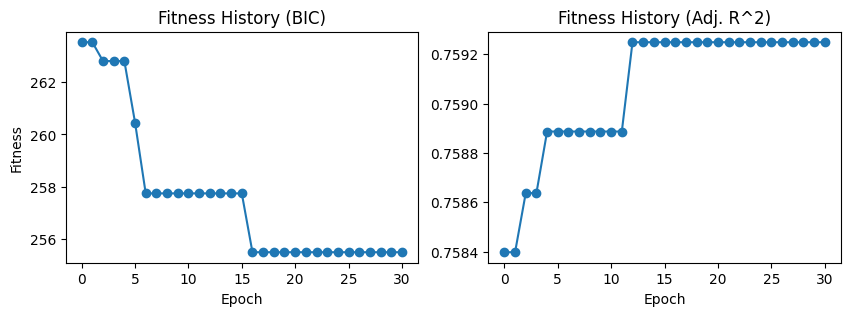

In [26]:
solver.problem.criterion = BIC
solver.minimize = True
best_gaBIC = solver.run(epochs = epochs, verbose = False, seed = 123)
BIC_fitH = solver.fit_history
BIC_lastUpdate = epochs - solver.last_update # Epoca dell'ultimo aggiornamento del miglior individuo 

solver.problem.criterion = ADJ_R2
solver.minimize = False
best_gaR2 = solver.run(epochs = epochs, verbose = False, seed = 123)
R2_fitH = solver.fit_history
R2_lastUpdate = epochs - solver.last_update

print("BIC:", best_gaBIC.fitness)
print("R2:", best_gaR2.fitness)
print("Last BIC Update:", BIC_lastUpdate)
print("Last R2 Update:", R2_lastUpdate)

plt.figure(figsize = (10,3))
plt.subplot(1, 2, 1)
plt.plot(BIC_fitH, "o-")
plt.title("Fitness History (BIC)")
plt.xlabel("Epoch")
plt.ylabel("Fitness")

plt.subplot(1, 2, 2)
plt.plot(R2_fitH, "o-")
plt.title("Fitness History (Adj. R^2)")
plt.xlabel("Epoch")

plt.show()

Risultati

In [27]:
res_df = pd.DataFrame({"Exhaustive": [best_eAIC[CRT_VALUE], best_eBIC[CRT_VALUE], best_eR2[CRT_VALUE]],
                        "Forward": [best_fAIC[CRT_VALUE], best_fBIC[CRT_VALUE], best_fR2[CRT_VALUE]],
                        "Backward": [best_bAIC[CRT_VALUE], best_bBIC[CRT_VALUE], best_bR2[CRT_VALUE]],
                        "Stepwise": [best_sAIC[CRT_VALUE], best_sBIC[CRT_VALUE], best_sR2[CRT_VALUE]],
                        "GA":[best_gaAIC.fitness, best_gaBIC.fitness, best_gaR2.fitness]}, index = ["AIC", "BIC", "ADJ. R2"])
res_df

,Exhaustive,Forward,Backward,Stepwise,GA
AIC,237.017458,237.017458,237.017458,237.017458,237.017458
BIC,255.479003,255.479003,255.479003,255.479003,255.479003
ADJ. R2,0.759248,0.759248,0.759248,0.759248,0.759248


### Osservazioni

**Osservazione n° 1** : Tutti gli algoritmi raggiungono l'ottimo per tutti e 3 i criteri di valutazione.

**Osservazione n° 2** : In tutti e 3 i casi l'algoritmo genetico ha raggiunto l'ottimo molto prima rispetto al limite massimo di epoche fissato, tuttavia ...

**Osservazione n° 3** : ... il numero di modelli testati dall'algoritmo genetico è comunque significativamente maggiore rispetto ai metodi di selezione iterativa